# Estimating model parameters with MLE and gradient descent (Chapter 3)

This notebook covers the code and explanation for the following experiments in Chapter 3 of the textbook "Fundamentals of Active Inference":
* Experiment 3A
* Experiment 3B
* Experiment 3C

==========================================================================
* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import torch

from matplotlib import cm
from torch.nn import MSELoss
from torch.distributions import MultivariateNormal, Normal

plt.rcParams.update({
    "text.usetex": True,
    "figure.dpi": 120})

mpl.style.use("seaborn-deep")

In Chapter 2, we explored the concept of hidden state estimation, also known as **inference**. This process entailed determining the value of an unobserved $x$, from an observed value of $y$, where $y$ could be a single sample or multiple samples. We made the assumption that our parameters of interest, the linear parameters $\theta = \left \{\beta_0, \beta_1 \right \}$ and other parameters $\phi = \left \{\sigma^2_y, \sigma^2_x, \mu_x \right \}$ were already learned, perhaps from the agent's previous encounters with food size in the environment. Perhaps we could say that in the agent's environmental niche, the food it typically encounters generally follows the linear relationship captured by the $\beta_0$ and $\beta_1$. Now suppose that the agent is in a new environment where this linear relationship has changed. It could use its past knowledge about the relationship between $x$ and $y$ to help it adjust (learn) new model parameter settings that are appropriate for the new environment so it can make better hidden state inferences. Note that what this means is that during the learning step, we can use our knowledge (or expectation) of $x$ along with $y$ to better inform us about how to adjust the model parameters.

Thus, in this notebook, our aim is to demonstrate the process of **parameter estimation**, which is the learning step. Then we can see how this learning step can inform the inference step. In this notebook, we will assume that the only parameters that the agent wishes to update are $\beta_0$ and $\beta_1$, the linear parameters. We are interested in just deterministic updates for these parameters, i.e., these parameters are not random variables. Therefore, this is a good application of maximum likelihood estimation (MLE) which we encountered at the end of Chapter 2. 

First, we need to define the MLE optimization problem. Our goal is to determine

$$
\theta^{MLE} := \underset{\theta}{\text{argmax}} \ell(\theta),
$$

where $ell(\theta)$ is our chosen log-likelihood function. In this case,

$$
\ell(\theta) := \sum_{i=1}^n \log \mathcal{N}(y_i, \beta_0 + \beta_1 x_i, \sigma^2_y).
$$

By taking the derivative of this log-likelihood with respect to either $\beta_0$ or $\beta_1$, setting the resulting equations equal to zero, and solving for $\beta_0$ or $\beta_1$, we get the following equations:

$$
\begin{aligned}
    \hat{\beta}_0 &= \bar{y} - \hat{\beta}_1 \bar{x} \\
    \hat{\beta}_1 &= \frac{\sum_{i=1}^n (x_i - \bar{x}) - \sum_{i=1}^n (y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} = \frac{cov_{xy}}{s^2_x}
\end{aligned}
$$

The equations are implemented in code below and give us the parameter estimates given that we have observed $x_i$ and $y_i$.

In [2]:
def beta_1(x, y):
    return np.cov(x, y)[0][1] / np.var(x, ddof=1)

def beta_0(x, y, beta_1_hat):
    return np.mean(y) - beta_1_hat * np.mean(x)

As before, we set up the environment and agent. We have the environment (generative process) defined as

$$
\mathscr{E} = 
\begin{cases}
    \mu = 2x_i + 3                         & \text{Generating function} \\
    y_i \sim \mathcal{N}(\mu, \sigma^2 = 1)    & \text{Gaussian noise} \\
\end{cases}
$$

and we have the agent (generative model) defined as

$$
\mathcal{M} = 
\begin{cases}
    p_{\theta, x_i, \sigma^2_y}(y_i) = \mathcal{N}(y_i; \beta_0 + \beta_1 x_i, \sigma^2_y) & \text{Likelihood} \\
    \theta := \left \{\beta_0, \beta_1 \right \}  & \text{Linear parameters} \\
    \phi := \left \{\sigma^2_y \right \}  & \text{Other parameters}
\end{cases}
$$

To make things less repetitive going forward, we will be wrapping the agent and environment within separate functions that we can call upon for different examples.

In [3]:
# Define the generating process
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

# Define an environment characterized by a linear generating function: y = beta_0 + beta_1x = 3 + 2x plus Gaussian noise
def environment(n, x_range, seed=False):
    # Initialize x and y arrays
    y_i           = np.zeros(n)
    x_i           = np.zeros(n)
    
    # Sample random x's to use that make up the (known) food sizes
    if seed:
        np.random.seed(seed)
    x_true        = np.random.choice(x_range, size=n)
    
    if seed:
        torch.manual_seed(seed)
    # For each x, pass through linear generating function (with beta_0=3, beta_1=2) and then add Gaussian noise (var_y)
    for idx, state in enumerate(x_true):
        mu        = G(state, beta_0=3, beta_1=2)
        y         = Normal(loc=mu, scale=1).sample()
        x_i[idx]  = state.tolist()
        y_i[idx]  = y.tolist()
    
    return y_i, x_i

# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)

## Experiment 3A: Analytic estimation of parameters

First, let's just see what happens when we use our parameter estimation equations. We will use the observed $x_i$ (food size) and $y_i$ (light intensity) to determine the values of $\beta_0$ and $\beta_1$.

**Note**: As a reminder, unlike the previous chapter where $x$ (food size) was unobserved, we are assuming in this scenario that the agent has already inferred a number of different food sizes and knows their relationship to light intensity, $y$. The aim in this experiment is to use this knowledge to try to refine its parameter settings (mean and variance of the likelihood) and then use these updated parameters to make a better inference about a new $x$. The status and data type of each variable in the model is summarized below.

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | observed   | deterministic |
| $y$      | observed   | probabilistic |
| $\theta$ | unobserved | deterministic |
| $\phi$   | known      | deterministic |

In [4]:
n            = 1000                                # Number of samples
y_i, x_i,    = environment(n, x_range, seed=4474)  # Get observed x_i and generated y_i from the environment

beta_1_hat   = beta_1(x_i, y_i)                    # Estimate for beta_1
beta_0_hat   = beta_0(x_i, y_i, beta_1_hat)        # Estimate for beta_0

# Print out results
print(f"beta_0 estimate: {np.round(beta_0_hat, 3)}")
print(f"true beta_0: {3}")
print("\n")
print(f"beta_1 estimate: {np.round(beta_1_hat, 3)}")
print(f"true beta_1: {2}")

beta_0 estimate: 2.963
true beta_0: 3


beta_1 estimate: 2.013
true beta_1: 2


This shows that are estimates are fairly good at $n=1000$ samples. As expected, the more samples, the better our estimation will be. 

Next, we could use these new learned parameter updates to perform inference on some new hidden state $x^*$. This is essentially identical to Experiment 2B from the previous chapter. We have *learned* new parameter settings that we can utilize for *inference*. First we need to define the functions we will use in ML estimation.
* In `learning_analytic()` we simply use the equations we listed above. These are our estimates for the model parameters.
* In `inference()` we recapitulate the inference process from `Experiment 2B`, passing in the estimations for the model parameters. Here we resample the environment and the agent has no knowledge of $x^*$ and must estimate it from $y$ alone.
* In `agent_mle()` we combine the learning and inference stages into one function.

One thing to note in this example is that during inference we will not use a prior. We will just use the log-likelihood.

In [5]:
def learning_analytic(x_i, y_i):
    beta_1_hat = beta_1(x_i, y_i)
    beta_0_hat = beta_0(x_i, y_i, beta_1_hat)
    return beta_0_hat, beta_1_hat

def inference(beta_0_hat, beta_1_hat, x_true, n, seed=False):
    
    # Define model parameters
    likelihood_mean    = G(x_range, beta_0=beta_0_hat, beta_1=beta_1_hat)
    likelihood_noise   = 1
    
    # Resample environment and ignore x since it is unobserved in inference
    if seed:
        torch.manual_seed(seed)
    y_i, _             = torch.tensor(environment(n, x_true))
    
    # Define generative model
    log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(y_i.unsqueeze(1)).sum(axis=0)
    posterior          = (log_likelihood - max(log_likelihood)).exp()
    
    return posterior

def sim_mle(n, n_inf, x_range, x_true, seed=False):
    
    y_i, x_i,                = environment(n, x_range, seed)                                  # Generate samples of x_i and y_i from environment
    beta_0_hat, beta_1_hat   = learning_analytic(x_i, y_i)                                    # LEARNING: Estimate beta_0 and beta_1 from x_i and y_i
    posterior                = inference(beta_0_hat, beta_1_hat, x_true, n_inf, seed=seed)    # INFERENCE: Infer hidden state for new set of y_i

    return posterior, beta_0_hat, beta_1_hat, y_i, x_i
    

In a moment, we will estimate the parameters using $50$ (noisy) points on the like $y=2x+3$ as input data. Before we do that, let's just get a visualize on this line and the data points around it.

<Figure size 720x480 with 0 Axes>

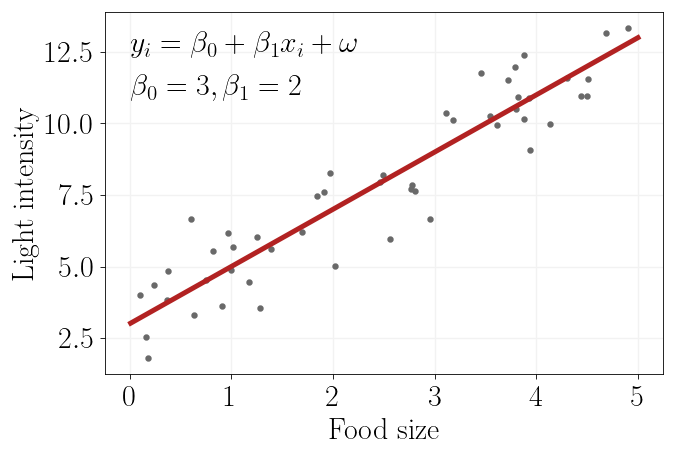

In [6]:
# Generate samples of x_i and y_i from environment
y_i, x_i = environment(n=50, x_range=x_range, seed=4334)

torch.manual_seed(5454)
mu = G(x_range, beta_0=3, beta_1=2)
E = Normal(loc=mu, scale=0.5)

fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range.tolist(), [G(elem, beta_0=3, beta_1=2) for elem in x_range],
        c="#B22222", linewidth=3, zorder=9)

# Noisy samples
ax.scatter(x_i, y_i,
        c="#696969", s=8, zorder=8)

ax.text(0, 12.5, r"$y_i = \beta_0 + \beta_1x_i + \omega$", fontsize=18)
ax.text(0, 11, r"$\beta_0 = 3, \beta_1 = 2$", fontsize=18)

# Axis labels and styling
ax.set_xlabel(r'$\textrm{Food size}$', fontsize=18)
ax.set_ylabel(r'$\textrm{Light intensity}$', fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=18,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)


In [7]:
# Generate n random samples for learning and n_inf random samples for inference
n                                       = 50
n_inf                                   = 100

# x_true for the inference step
x_true                                  = [2.2]

# Simulation - sample environment then perform learning and inference
posterior, beta_0_hat, beta_1_hat, _, _ = sim_mle(n, n_inf, x_range, x_true, seed=4334)

# Calculate posterior mode for hidden state inference along with beta_0 and beta_1 estimates
x_hat                                   = np.round(((np.argmax(posterior) + 1) / 100).tolist(), 3)
beta_0_hat                              = np.round(beta_0_hat, 3)
beta_1_hat                              = np.round(beta_1_hat, 3)

# Print out the results
print(f"True hidden state = {x_true[0]}")
print(f"Estimate of hidden state = {x_hat}")
print(f"Estimate of beta_0 = {beta_0_hat}")
print(f"Estimate of beta_1 = {beta_1_hat}")

True hidden state = 2.2
Estimate of hidden state = 2.21
Estimate of beta_0 = 3.062
Estimate of beta_1 = 1.959


/tmp/ipykernel_15077/3805937877.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  y_i, _             = torch.tensor(environment(n, x_true))


As we can see, the estimates of $\beta_0$ and $\beta_1$ are fairly close to their true values and this gives us a good hidden state estimate. Next we perform the same estimation multiple times so we can plot the parameter estimation and associated error. First we create a function `estimate_param_hidden_state()` that returns the parameter and hidden state estimate. This just wraps the simulation process so we can run it over and over again and see how the randomness in the samples produce different estimates.

In [8]:
def estimate_param_hidden_state(n, n_inf, x_range, x_true, seed):
    posterior, b_0_hat, b_1_hat, y_i, x_i = sim_mle(n, n_inf, x_range, x_true, seed)
    x_hat = ((np.argmax(posterior) + 1) / 100).tolist()
    
    return x_hat, b_0_hat, b_1_hat, y_i, x_i

Now we are going to repeatedly run this simulation and see what the results look like for different random samples.

In [9]:
# Generate n random samples for learning and n_inf random samples for inference
n            = 8   # Number of random samples for learning
n_inf        = 8  # Number of random samples for inferences
n_iter       = 100  # Number of iterations to repeat simulatio

# Initialize empty arrays to fill across the simulation
x_hats       = np.zeros(n_iter)   # Array of x inferences
beta_0_hats  = np.zeros(n_iter)   # Array of learned beta_0s
beta_1_hats  = np.zeros(n_iter)   # Array of learned beta_1s

# True x used in inference
x_true       = [2.2]

# Create seeds for each iteration of the simulation
np.random.seed(3424)
seeds = np.random.randint(100, 10000, n_iter)

# Repeat simulation n_iter times
for i in range(n_iter):
    x_hat, b_0_hat, b_1_hat, y_i, x_i = estimate_param_hidden_state(n, n_inf, x_range, x_true, seeds[i])
    x_hats[i] = x_hat
    beta_0_hats[i] = b_0_hat
    beta_1_hats[i] = b_1_hat

# Collect all results of estimates    
sim_dat = pd.DataFrame({
    "beta_0_hat": beta_0_hats,
    "beta_1_hat": beta_1_hats,
    "x_hat": x_hats,
})

# Determine the error in x_hat by subtracting from the true x
sim_dat["error"] = x_true[0] - sim_dat["x_hat"]

Now we make two plots. On the left we plot 10 different possible lines we could draw with our different estimates of $\beta_0$ and $\beta_1$ in each run of the simulation. On the right we plot all of the $\beta_0$ and $\beta_1$ estimates and color code each point with the resulting error in $x$ during inference.

/tmp/ipykernel_15077/3177759828.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=axes[1])


<Figure size 720x480 with 0 Axes>

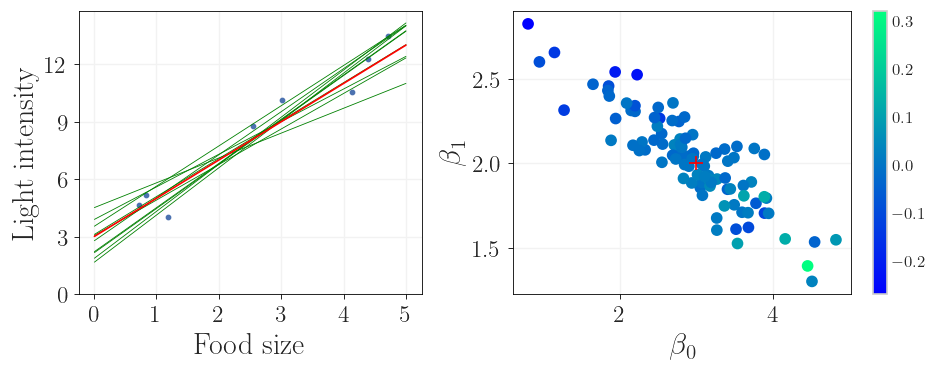

In [10]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(8,3.2), gridspec_kw={'width_ratios': [1.7, 2.1]})

"""" LEFT PLOT """
# Scatter plot of all x and y points generated
axes[0].scatter(x_i, y_i, s=6)

# Create possible lines with the first 10 beta_0 or beta_1 estimates
for beta_0, beta_1 in zip(beta_0_hats[:10], beta_1_hats[:10]):
    axes[0].plot(x_range.tolist(), [G(elem, beta_0=beta_0, beta_1=beta_1) for elem in x_range],
        c="green",
        linewidth=0.5)

# True parameter line in red    
axes[0].plot(x_range.tolist(), [G(elem, beta_0=3, beta_1=2) for elem in x_range],
    c="red",
    linewidth=1)

""" RIGHT PLOT """
# Plot all beta_0 and beta_1 estimates and color according to the error in the hidden state estimate
im = axes[1].scatter(sim_dat["beta_0_hat"], sim_dat["beta_1_hat"], 
                c=sim_dat["error"], cmap="winter")
fig.colorbar(im, ax=axes[1])

axes[1].plot(3, 2, marker="+", color="red", markersize=8)

""" GLOBAL PLOT SETTINGS """
# Axis labels and styling
axes[0].set_xlabel(r'$ \textrm{Food size}$', fontsize=18)
axes[0].set_ylabel(r'$ \textrm{Light intensity}$', fontsize=18)
axes[1].set_xlabel(r'$ \beta_0$', fontsize=18)
axes[1].set_ylabel(r'$ \beta_1$', fontsize=18)

# Axis ranges
axes[0].set_xticks(np.arange(0,6,1))
axes[0].set_yticks(np.arange(0,15,3))

# Apply to both plots
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        labelsize=14,
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

ax.set_axisbelow(True)
fig.tight_layout()

## Experiment 3B: Finding parameters with gradient descent

Next we will show how to find parameters estimates using gradient descent. In order to perform gradient descent, we will need to first specify our loss function. We will use the negative log-likelihood,

$$
-\ell(\theta) = - \sum_{i=1}^n \log \mathcal{N}(y_i; \beta_0 + \beta_1 x_i, \sigma^2_y).
$$

In [11]:
def nll_mle(beta_0, beta_1):
    
    # Parameters
    likelihood_mean = G(x_i, beta_0, beta_1)
    likelihood_noise = 1
    
    # Model
    ll = Normal(loc=likelihood_mean, 
                scale=likelihood_noise).log_prob(y_i).sum(axis=0)
    nll = -ll
    
    return nll

The next step is to set up the generating function, environment, and range of $x$. We will utilize the same code we have used previously for this. Then we can generate data.

In [12]:
# Generate data points and convert to tensor
y_i, x_i = environment(500, x_range, seed=5453)
x_i = torch.tensor(x_i)
y_i = torch.tensor(y_i)

In gradient descent we update our parameter weights in the direction of the negative gradient along our loss function. This means that in order to perform gradient descent we need to pick a starting position on the loss function (the initialization), a learning rate specifiying how big we are going to step down the loss function, and then loop through the update process over $i$ iterations. The gradient descent process is captured by the following equation:

$$
\theta = \theta - \alpha \frac{- \partial {\ell(\theta)}}{\partial \theta}
$$

In the code below, we initialize the parameters randomly from -100 to 100. Then we place these values into the a `weights` list so we can view the progress of the weight updates later. We will also keep track of the costs which is the output of the NLL for a given pair of $\beta_0$ and $\beta_1$, our current parameters. This initial cost will be the cost at the random initialization we chose for the parameters. After specifiying the learning rate we also need to turn the parameter vector, `w`, into a tensor and make sure it can be differentiated.

In [16]:
# Initialize weights
beta_0_init = np.random.uniform(low=-100, high=100)
beta_1_init = np.random.uniform(low=-100, high=100)
w = [beta_0_init, beta_1_init]
print(f"Initializing at: {w}.")

# Initialize empty arrays for history weights and costs
n_iter = 700
weights = [w]
costs = [nll_mle(w[0], w[1])]

# Learning rate
alpha = 0.0001

# Turn weight vector into a tensor that autograd can differentiate
w = torch.tensor(w, requires_grad=True)

Initializing at: [-97.95149226385516, -26.239077249823566].


Finally, we perform gradient descent. For the $i$ iterations, we calculate the negative log-likelihood at the current parameter setting, compute the gradient, and then change theta proportional to the gradient. The code here is very similar to the code in the notebook from Chapter 2 *2e_mle_map.ipynb* where it is explained in more detail.

In [17]:
# Loop over each iterations and perform gradient descent
for i in range(1, n_iter):
    nll_w = nll_mle(w[0], w[1])   # Calculate NLL at current weight
    nll_w.backward()              # Compute tensor gradient
    
    with torch.no_grad():
        w -= (alpha * w.grad)     # Change theta proportional to gradient
        w.grad.zero_()            # Gradients to zero
        
    weights.append(w.tolist())          # Record new weight update
    costs.append(nll_mle(w[0], w[1]))   # Evaluate costs at new weights
    
print(f"Final weights: {weights[-1]}")

Final weights: [2.9280202388763428, 2.0309605598449707]


The results of the experiment are plotted below.

**Note**: In order to plot in 3D, we need to compute all combinations of variables on both axes. The `np.meshgrid()` function allows us to set up a grid given a range of points. Then we pass these points to a vectorized version of the function we wish to plot. The `np.vectorize` function automatically computes the $z$-axis values at all points on the grid, i.e., the cartesian product of $X \times Y$, all possible combinations. 

/tmp/ipykernel_180374/2561886646.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(fill)


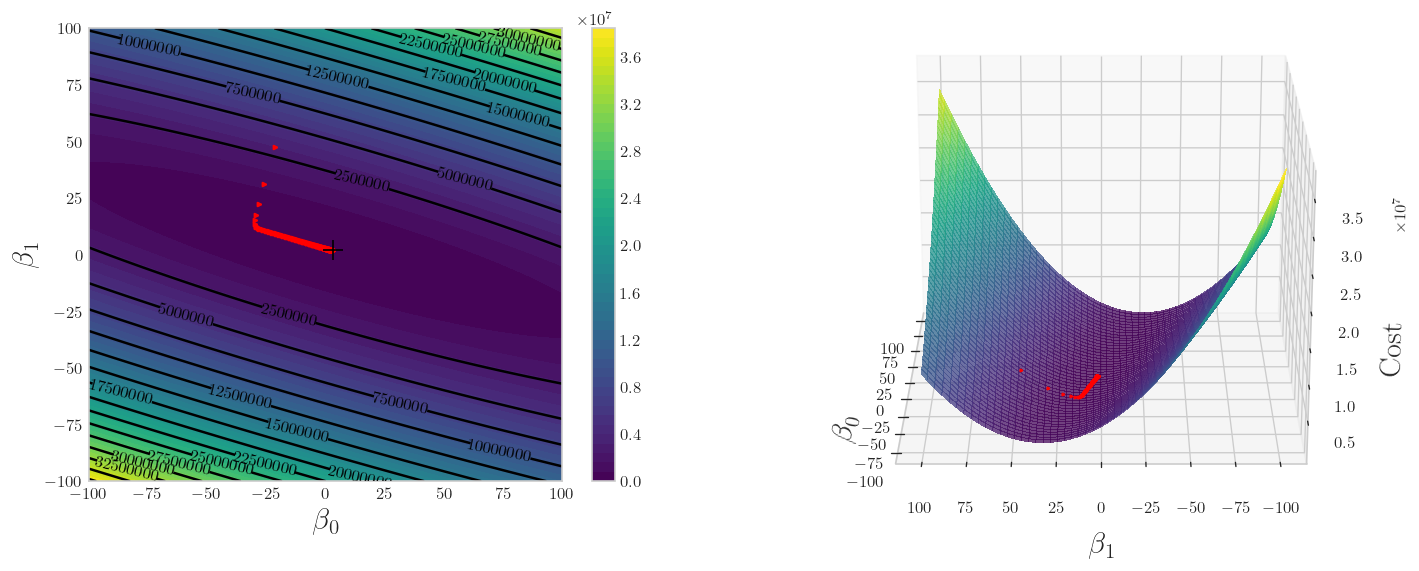

In [27]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(facecolor=(1,1,1), figsize=(14,5))
# fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(6, 3))

""" LEFT PLOT """
ax = fig.add_subplot(1, 2, 1)

# Set up grid
b0_range = np.linspace(-100, 100, 200)
b1_range = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(b0_range, b1_range)

# Vectorize NLL and compute the costs at all combinations of beta_0 and beta_1
nll_mle_vec = np.vectorize(nll_mle)
z = nll_mle_vec(X, Y)

# Plot the contours of the costs and fill them in
contours = ax.contour(X, Y, z, levels=15, colors='k')
fill = ax.contourf(X, Y, z, levels=50, cmap="viridis")

# Compute the updates of beta_0 and beta_1 for each iteration of gradient descent
beta_0_hat = [weight[0] for weight in weights]
beta_1_hat = [weight[1] for weight in weights]

# Plot the beta_0 and beta_1 updates across the loss function
ax.plot(beta_0_hat, beta_1_hat, "r>", ms=2.5)
ax.plot(3, 2, marker="+", color="black", markersize=12)   # True generating parameters

# Axis labels
ax.set_xlabel(r'$\beta_0$', fontsize=18)
ax.set_ylabel(r'$\beta_1$', fontsize=18)

# Labels contours and add colorbar
plt.clabel(contours)
plt.colorbar(fill)

""" RIGHT PLOT """
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot 3D negative log-likelihood
ax.plot_surface(X, Y, z, cmap=cm.viridis, antialiased=False, alpha=0.75)

# Compute the costs at each weight update
cost_at_weight = [nll_mle(weight[0], weight[1]).tolist() for weight in weights]

# Plot update along loss surface 
ax.plot(beta_0_hat, beta_1_hat, cost_at_weight, "r>", ms=1.5, zorder=10)

# Change 3D plot camera view
ax.view_init(20, 180)

# Axis labels
ax.set_xlabel(r'$\beta_0$', fontsize=18)
ax.set_ylabel(r'$\beta_1$', fontsize=18)
ax.set_zlabel(r'$\textrm{Cost}$', fontsize=18)

ax.dist = 7.5

## Experiment 3C: Multiple linear regression

In this experiment, we show how we can estimate the parameter values for an arbitrary number of $\beta$'s. In other words, all of our $\beta$'s of interest will be collected into a parameter vector $\boldsymbol{\theta} = \left [\beta_0, \dots, \beta_p \right ]^T$ and we can solve for all $\beta$'s simultaneuously. We will be using matrix notation in this example. If you are unfamiliar with this notation, it is explained in $\sect 3.2$ of the textbook. In matrix form, the generative process is

$$
\mathscr{E} = 
\begin{cases}
    y_i \sim \mathcal{N}(y_i; \boldsymbol{x}^T_i \boldsymbol{\theta}, \boldsymbol{\Sigma}_y = \sigma^2_y \boldsymbol{I})    & \text{Noisy generating function} \\
    \boldsymbol{\theta} = \left [\beta_0 = 3, \beta_1 = 2 \right ]^T & \text{Parameters}
\end{cases}
$$

and the generative model is

$$
\mathcal{M} = 
\begin{cases}
    p_{\theta, X, \sigma^2y}(y_i) = \mathcal{N}(y_i; \boldsymbol{x}^T_i \boldsymbol{\theta}, \sigma^2_y \boldsymbol{I}) & \text{Likelihood} \\
    \boldsymbol{\theta} := \left [\beta_0, \beta_1 \right ]^T  & \text{Linear parameters} \\
    \phi := \left \{\sigma^2_y \right \}  & \text{Other parameters}
\end{cases}
$$

Thus, we have a generating function as $G(x; \theta) = \boldsymbol{x}^T_i \boldsymbol{\theta}$, where $x$ is a vector of food sizes (dimension $p$, and with a $1$ inserted in the front of the vector) and $\theta$ is the parameter vector governing the relationship between the linear combination of $x$ elements. Each time the generative sample is processed, the sample $x$ is a vector and $y$ is a scalar. 

To learn the parameters from the data we use the following equation, the **normal equation**:

$$
\boldsymbol{\theta} = \underbrace{(\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T}_{\text{pseudoinverse}} \boldsymbol{y} = \boldsymbol{X}^{+} \boldsymbol{y}.
$$

To generate data that is of the correct format, we will first construct $\mathcal{X} := \left \{ \boldsymbol{x}_1, \dots \boldsymbol{x}_n \right \}$. From this and the generating function, we will construct $\mathcal{Y} = \left \{y_1, \dots, y_n \right \}$. Together, this forms our dataset $\mathcal{D} = \left \{\mathcal{X}, \mathcal{Y} \right \} = \left \{\boldsymbol{x}_i, y_i \right \}^n_{i=1}$. Then we will assemble the vectors of $\mathcal{X}$ into a data matrix $\boldsymbol{X}$ that we can use in the normal equation. 

In [29]:
def environment(n, p, theta, x_range, seeds=None):
    # Initialize empty x and y arrays and list to collect x vectors
    y_i = np.zeros(n)
    x_i = np.zeros((n, p + 1))   # p + 1 because we are going to insert a "1" in the first position of the x vector
                                 # to account for the intercept when we perform x.T theta.
    X   = []

    for i in range(n):
        
        # Create a random sample of x
        if seeds is not None:
            np.random.seed(seeds[i])
        x = np.random.choice(x_range, size=p)          # Create vector of size p (one sample) [1 x p]
        x = np.insert(x, 0, 1)                         # Insert a 1 in front of the vector

        if seeds is not None:
            torch.manual_seed(seeds[i])
        noise = Normal(loc=0, scale=1).sample()        # Generate noise for y
        y = x.T @ theta + noise                        # y = x.T theta + error/noise
        
        # Populate data matrix and data vectors
        X.append(x)
        x_i[i] = x
        y_i[i] = y
        
    X = torch.tensor(np.array(X, dtype=np.float64))  # Convert X to a matrix form
    return x_i, y_i, X


Now we can generate some data. We will generate $50$ samples of $x \in \mathbb{R}^p=1$ which makes $x$ a scalar. We will add a $1$ to the front of this $x$ in the `environment()` function. We also need the true theta which we will set as $\theta = \left [3, 2 \right ]^T$.

In [30]:
n       = 500                       # Number of samples
p       = 1                         # Dimension of x
x_range = torch.linspace(           # the range of x in our grid
    start=0.01, end=5, steps=500)   
theta   = np.array([3, 2])          # beta_0 = 3, beta_1 = 2

# Get seed
np.random.seed(3244)
seeds = np.random.randint(100, 10000, n)

# Create samples from environment
x_i, y_i, X = environment(n, p, theta, x_range, seeds=seeds)

Next, we turn the normal equation into code. Note that there are two ways we can write this equation and both are shown below. They will give us the exact same result. The first uses the full normal equation while the second uses the pseudoinverse of $\boldsymbol{X}$ with `torch.linalg.pinv()`. We will use the second form.

In [31]:
# Using theta = (X^T X)^(-1) X^T y
def learn_full(X, y):
    theta = torch.inverse(X.t() @ X) @ X.t() @ y
    return theta

# Using theta = X^+ y
def learn(X, y):
    theta = torch.linalg.pinv(X) @ y
    return theta

We can easily use the `learn()` function to generate the ML estimates for $\hat{\theta}$ after we sample from the environment. 

In [32]:
theta_hat = learn(X, y_i)

print(f"Theta: {np.round(theta, 3)}")
print(f"Theta_hat: {np.round(theta_hat.tolist(), 3)}")

Theta: [3 2]
Theta_hat: [3.117 1.97 ]


Now we use either 2 or 5 parameters and run the estimates for theta for 1-100 samples to see how our estimates get more accurate as our sample size increases. We use the root mean squared error (RMSE) to compute the deviations from the expected value.

**Note**: RMSE is the square root of the mean squared error (MSE). By taking the square root it returns the error into the units that they are measured in rather than squared units.

In [33]:
# Constants
theta = np.array([3, 2])   # Parameter values
p = 1
n = 100

theta_errors_2 = []        # Error for two parameter

for i in range(1, n):
    x_i, y_i, X = environment(i, p, theta, x_range, seeds=seeds)
    theta_hat = learn(X, y_i)
    theta_error = torch.sqrt(MSELoss()(torch.tensor(theta), theta_hat))
    theta_errors_2.append(theta_error.tolist())

In [34]:
# Constants
theta = np.array([3, 2, 4, 5, 6])   # Parameter values
p = 4                  # Size of x
n = 100

theta_errors_5 = []                 # Error for two parameter

for i in range(1, n):
    x_i, y_i, X = environment(i, p, theta, x_range, seeds=seeds)
    theta_hat = learn(X, y_i)
    theta_error = torch.sqrt(MSELoss()(torch.tensor(theta), theta_hat))
    theta_errors_5.append(theta_error.tolist())

<Figure size 720x480 with 0 Axes>

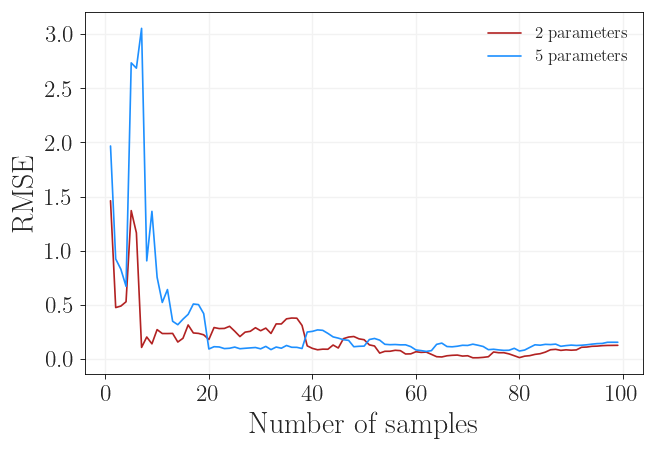

In [35]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Main plot
ax.plot(np.array(range(1, n)), theta_errors_2,
        c="#B22222", linewidth=1, label=r"$2 \; \textrm{parameters}$")

ax.plot(np.array(range(1, n)), theta_errors_5,
        c="#1E90FF", linewidth=1, label=r"$5 \; \textrm{parameters}$")

# Axis labels and styling
ax.set_xlabel(r'$\textrm{Number of samples}$', fontsize=18)
ax.set_ylabel(r'$\textrm{RMSE}$', fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

plt.legend()


We can also see how well our estimate matches the true line for two parameters. To do this, we simple take the parameters we have estimated and plot the line that would result from these parameters. Additionally, we add the scatter of points to the plot that we had used to estimate the parameters.

/tmp/ipykernel_180374/3662230677.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  y_gen = [(np.insert(x, 0, 1).T @ theta).tolist() for x in x_range]


<Figure size 720x480 with 0 Axes>

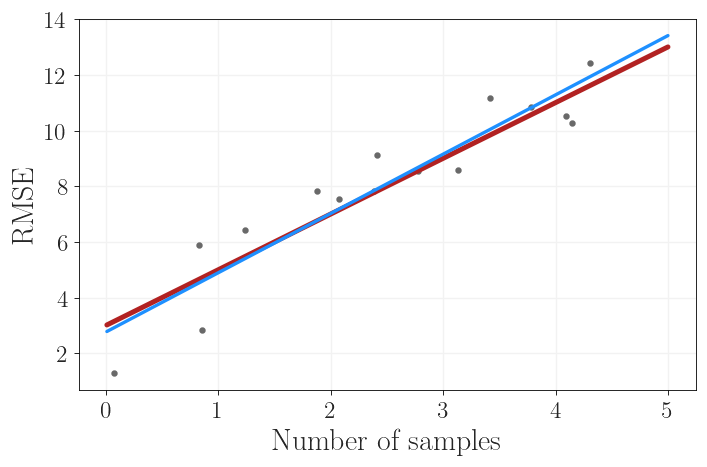

In [36]:
theta = np.array([3, 2])   # Parameter values
p = 1
n = 15
x_i, y_i, X = environment(n, p, theta, x_range, seeds=seeds)
theta_hat = learn(X, y_i)

fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

y_gen = [(np.insert(x, 0, 1).T @ theta).tolist() for x in x_range]
y_est = [(np.insert(x, 0, 1).T @ theta_hat.numpy()).tolist() for x in x_range]
ax.scatter(x_i[:, 1], y_i, s=8, c="#696969", zorder=9)

ax.plot(x_range, y_gen,
        c="#B22222",
        linewidth=3, zorder=10)

ax.plot(x_range, y_est,
        c="#1E90FF",
        linewidth=2, zorder=10)

# Axis labels and styling
ax.set_xlabel(r'$\textrm{Number of samples}$', fontsize=18)
ax.set_ylabel(r'$\textrm{RMSE}$', fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

fig.tight_layout()